In [194]:
if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    sys.path.append(str(curr_file_path.parent))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from aux_funcs import colored_line
# from aux_funcs import parse_string_with_regex, ordered_colors_from_cmap

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 3.0

In [181]:
def load_hidden_activity(data_path, averaging_size=1):
    file_names = glob.glob(data_path)
    data = []
    for file_name in file_names:
        print(file_name)
        data_for_file = np.load(file_name)
        print(data_for_file.shape)
        data.append(data_for_file)
    data = np.concatenate(data, axis=1)
    if averaging_size == 1:
        return data
    reduced_data = np.empty((data.shape[0], int(data.shape[1] / averaging_size)))
    for k in range(0, int(data.shape[1] / averaging_size) * averaging_size, averaging_size):
        reduced_data[:, int(k / averaging_size)] = data[:, k:k + averaging_size].mean(axis=1)
    return reduced_data

def load_state_data(data_path, indices=[], all=False):
#     file_names = glob.glob(data_path)
    file_names = sorted(os.listdir(data_path))
    print(file_names)
    for fidx, file_name in enumerate(file_names):
        if all or fidx in indices or (len(indices) == 0 and fidx + 1 == len(file_names)):
            data_for_file = pickle.load(open(os.path.join(data_path, file_name), 'rb'))
            yield data_for_file

def parse_session(data_path, update_num=None):
    indices = [] if update_num is None else [update_num]
    state_data = load_state_data(
        data_path,
        all=True,
    )

    features = [
        'current_patch_num',
        'reward_site_idx',
        'current_reward_site_attempted',
        'agent_in_patch',
        'patch_reward_param',
        'action',
        'reward',
    ]

    all_time_series_dicts = []

    for d in state_data:
        for env_idx in range(20):
            features_to_time_series_dict = {}
            for f in features:
                features_to_time_series_dict[f] = np.zeros((len(d)))
            
            for k in np.arange(len(d)):
                for f in features:
                    features_to_time_series_dict[f][k] = d[k][f][env_idx]

        
            dwell_time = np.zeros((len(d)))
            rewards_seen_in_patch = np.zeros((len(d)))
            
            for idx in np.arange(0, len(d)):
                if idx > 0 and features_to_time_series_dict['action'][idx] == 0:
                    dwell_time[idx] = dwell_time[idx-1] + 1
                else:
                    dwell_time[idx] = 0

                if features_to_time_series_dict['agent_in_patch'][idx]:
                    if idx > 0:
                        rewards_seen_in_patch[idx] = rewards_seen_in_patch[idx-1] + features_to_time_series_dict['reward'][idx]
                    else:
                        rewards_seen_in_patch[idx] = features_to_time_series_dict['reward'][idx]
        
            features_to_time_series_dict['dwell_time'] = dwell_time
            features_to_time_series_dict['rewards_seen_in_patch'] = rewards_seen_in_patch
            all_time_series_dicts.append(features_to_time_series_dict)
        
    return all_time_series_dicts

def find_patch_trajectories(agent_in_patch_ts):
    starts_and_stops = []
    start_idx = None
    for k in np.arange(len(agent_in_patch_ts)):
        if agent_in_patch_ts[k] > 0:
            if start_idx is None:
                start_idx = k
        elif (k > 0 and agent_in_patch_ts[k-1] > 0 and start_idx is not None):
            starts_and_stops.append(slice(start_idx, k))
            start_idx = None
    return starts_and_stops

def find_odor_site_trajectories(odor_site_indices):
    starts_and_stops = []
    start_idx = None
    for k in np.arange(len(odor_site_indices)):
        if odor_site_indices[k] >= 0:
            if start_idx is None:
                start_idx = k
        elif (k > 0 and odor_site_indices[k-1] >= 0 and start_idx is not None):
            starts_and_stops.append(slice(start_idx, k))
            start_idx = None
    return starts_and_stops

def find_trajectories_by_patch_type(session_data):
    patch_starts_and_ends = find_patch_trajectories(session_data['agent_in_patch'])
    trajs_by_patch_type = [[], [], []]
    for traj_idx, patch_traj_indices in enumerate(patch_starts_and_ends):
        patch_num = int(session_data['current_patch_num'][patch_traj_indices][0])
        trajs_by_patch_type[patch_num].append(patch_traj_indices)
    return trajs_by_patch_type

def find_odor_site_trajectories_by_patch_type(session_data):
    patch_starts_and_ends = find_odor_site_trajectories(session_data['reward_site_idx'])
    trajs_by_patch_type = [[], [], []]
    for traj_idx, patch_traj_indices in enumerate(patch_starts_and_ends):
        patch_num = int(session_data['current_patch_num'][patch_traj_indices][0])
        trajs_by_patch_type[patch_num].append(patch_traj_indices)
    return trajs_by_patch_type

In [182]:
data = load_hidden_activity('../data/rl_agent_outputs/test_run_all_same_seed_2024-10-03_07_57_15_997601/hidden_activity/*.npy')
print(data.shape)
all_session_data = parse_session('../data/rl_agent_outputs/test_run_all_same_seed_2024-10-03_07_57_15_997601/state')

../data/rl_agent_outputs/test_run_all_same_seed_2024-10-03_07_57_15_997601/hidden_activity\00000.npy
(5000, 20, 128)
../data/rl_agent_outputs/test_run_all_same_seed_2024-10-03_07_57_15_997601/hidden_activity\00001.npy
(5000, 20, 128)
../data/rl_agent_outputs/test_run_all_same_seed_2024-10-03_07_57_15_997601/hidden_activity\00002.npy
(5000, 20, 128)
../data/rl_agent_outputs/test_run_all_same_seed_2024-10-03_07_57_15_997601/hidden_activity\00003.npy
(5000, 20, 128)
../data/rl_agent_outputs/test_run_all_same_seed_2024-10-03_07_57_15_997601/hidden_activity\00004.npy
(5000, 20, 128)
../data/rl_agent_outputs/test_run_all_same_seed_2024-10-03_07_57_15_997601/hidden_activity\00005.npy
(5000, 20, 128)
../data/rl_agent_outputs/test_run_all_same_seed_2024-10-03_07_57_15_997601/hidden_activity\00006.npy
(5000, 20, 128)
../data/rl_agent_outputs/test_run_all_same_seed_2024-10-03_07_57_15_997601/hidden_activity\00007.npy
(5000, 20, 128)
(5000, 160, 128)
['00000.pkl', '00001.pkl', '00002.pkl', '00003.

[-1.9784579282633854, -0.6545523263009205, -0.12067901566835837, 0.31097337407291203, -0.05577309070391978, 0.5099588098535857, -0.18790628936364695, 0.8295365105673411, 0.7677828827611126, 0.8812617970509398, 0.8733293150328735, 0.8816981205876806, 0.900679311502504, 0.9010182008012315, 0.8579225662765815, 0.8792493112487576, 0.8903026486065556, 0.9060593347369426, 0.9076262438216341, 0.9088060442753083, 0.9114899914666962, 0.911134065029214, 0.8916026348830014, 0.9063726005193621, 0.913264714595661, 0.9138534722686757, 0.9140056297482889, 0.9135660855325604, 0.916981432860399, 0.9152721718506177, 0.9016300885209829, 0.9094705925956574, 0.9118420118450508, 0.9112707228838517, 0.9141904646040574, 0.915417579151649, 0.916612308250442, 0.9141956862331565, 0.9112223240695765, 0.9141133870163336, 0.9182576659124423, 0.91666132353479, 0.9151965949457556, 0.9172872941520036, 0.9170478567055628, 0.9147700681769575, 0.9137791344385747, 0.9164377404247054, 0.9171449056818114, 0.9166821767323629

Text(0.5, 1.0, 'Decoding reward site number from hidden state')

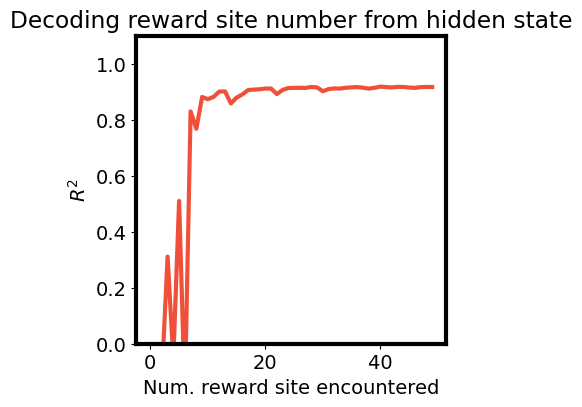

In [172]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

pred_accuracies = []
    
for i in range(0, 50):
    train_hidden = []
    test_hidden = []
    train_reward_params = []
    test_reward_params = []

    for env_idx in range(0, 160):
        session_data = all_session_data[env_idx]
        trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
        for k in range(3):            
            for i_prime in range(i, i+1):
                train_hidden.append(data[trajs_by_patch_type[k][i_prime], env_idx, :])
                train_reward_params.append(session_data['reward_site_idx'][trajs_by_patch_type[k][i_prime]])

            for i_prime in range(1, 21):
                test_hidden.append(data[trajs_by_patch_type[k][-1-i_prime], env_idx, :])
                test_reward_params.append(session_data['reward_site_idx'][trajs_by_patch_type[k][-1-i_prime]]) 


    train_hidden = np.concatenate(train_hidden, axis=0)
    test_hidden = np.concatenate(test_hidden, axis=0)
    train_reward_params = np.concatenate(train_reward_params)
    test_reward_params = np.concatenate(test_reward_params)
    
    reg = LinearRegression().fit(train_hidden, train_reward_params)
    pred_accuracies.append(reg.score(test_hidden, test_reward_params))

axs.plot(np.arange(len(pred_accuracies)), pred_accuracies, c='#f05039', alpha=1, lw=3)
print(pred_accuracies)
axs.set_ylim(0, 1.1)
axs.set_ylabel(r'$R^2$')
axs.set_xlabel('Num. reward site encountered')
axs.set_title('Decoding reward site number from hidden state')

[0.7926573904897432, 0.8022042619798286, 0.8841045343599648, 0.92855092536325, 0.9581788570728322, 0.8785946711135793, 0.9559695294735371, 0.9931516398761424, 0.907059808705595, 0.9874735443434927, 0.9920068727342518, 0.9962151374542222, 0.9961923220398256, 0.9968738499376771, 0.9968163822986269, 0.9961486819000158, 0.9922497324787123, 0.9959043374124831, 0.9966848769469105, 0.9970274649382503, 0.9968991034393236, 0.9971548533362415, 0.9970424179092309, 0.996729061137921, 0.9966215135011388, 0.9969341744930283, 0.997008899941217, 0.9971276162990954, 0.9971839299319977, 0.9971575801994251, 0.9972016466759908, 0.9969653941090345, 0.9967632834007314, 0.9969527465984603, 0.9971100764145493, 0.9969171114601096, 0.9968998049371715, 0.9970746391185731, 0.9971316643626364, 0.9970510559369786, 0.9969891689702605, 0.9971245231545178, 0.9971554708728553, 0.9971802687589546, 0.9968554725698661, 0.9971366939804341, 0.9970964368529165, 0.9970651733884212, 0.9970882326232254, 0.9971836939879112]


Text(0.5, 1.0, 'Decoding patch type from hidden state')

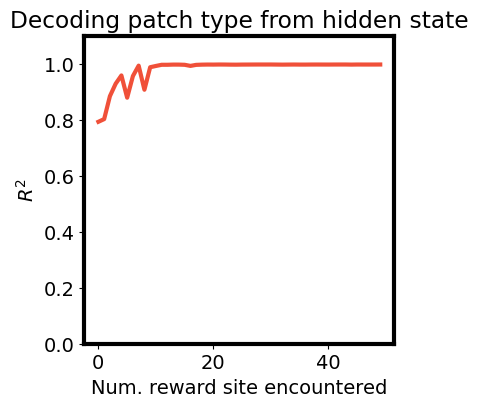

In [185]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

pred_accuracies = []
    
for i in range(0, 50):
    train_hidden = []
    test_hidden = []
    train_reward_params = []
    test_reward_params = []

    for env_idx in range(0, 160):
        session_data = all_session_data[env_idx]
        trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
        for k in range(3):
            for i_prime in range(i, i+1):
                if i_prime < len(trajs_by_patch_type[k]) - 20:
                    train_hidden.append(data[trajs_by_patch_type[k][i_prime], env_idx, :])
                    train_reward_params.append(session_data['current_patch_num'][trajs_by_patch_type[k][i_prime]])

            for i_prime in range(1, 21):
                test_hidden.append(data[trajs_by_patch_type[k][-1-i_prime], env_idx, :])
                test_reward_params.append(session_data['current_patch_num'][trajs_by_patch_type[k][-1-i_prime]]) 


    train_hidden = np.concatenate(train_hidden, axis=0)
    test_hidden = np.concatenate(test_hidden, axis=0)
    train_reward_params = np.concatenate(train_reward_params)
    test_reward_params = np.concatenate(test_reward_params)
    
    reg = LinearRegression().fit(train_hidden, train_reward_params)
    pred_accuracies.append(reg.score(test_hidden, test_reward_params))

axs.plot(np.arange(len(pred_accuracies)), pred_accuracies, c='#f05039', alpha=1, lw=3)
print(pred_accuracies)
axs.set_ylim(0, 1.1)
axs.set_ylabel(r'$R^2$')
axs.set_xlabel('Num. reward site encountered')
axs.set_title('Decoding patch type from hidden state')

[-1.0017598107386383, -0.8954661503581458, -0.9431750055980654, -7.240705243843706, -29.210110251028322, -6.137190980821634, -3.7833126213452504, -0.1387158094772616, -5.029325848612619, -0.15120845759678492, -0.1976086466364786, -0.10989181102685808, -0.07658057763653003, -0.053271711932159516, -0.03390814143927634, -0.01567554541802041, -0.10562721984299661, -0.1229299580922949, -0.10512175496613585, -0.025578086312276538, -0.013935077476411983, -0.03286285976610803, 0.02633340550454555, 0.015704139574695075, -0.03434380245731794, -0.07575969149020412, -0.06023548235907894, 0.002850775171507447, -0.00040262306581162477, -0.018478206305678757, 0.03895327203282284, 0.03116750642192656, 0.014461101495811146, 0.011706753244707269, 0.012193558533326598, 0.031010315962375468, 0.0031664938301388945, 0.03193028407579812, 0.03603498142130923, 0.005761479217625487, 0.01650895515220263, 0.009676140872349914, 0.01590917192320651, 0.02893263584673178, 0.0175905766603619, 0.029742494341841508, 0.0

Text(0.5, 1.0, 'Decoding patch reward param from hidden state')

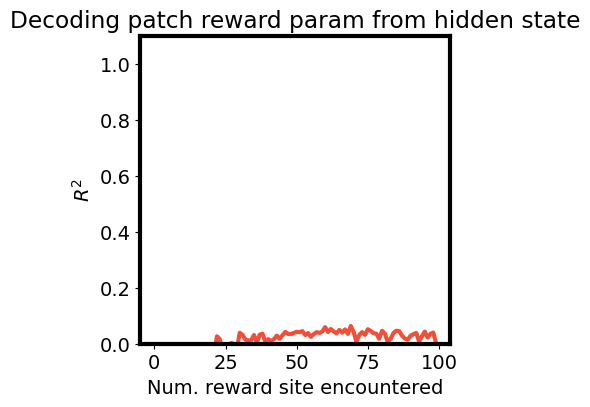

In [178]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

pred_accuracies = []
    
for i in range(0, 100):
    train_hidden = []
    test_hidden = []
    train_reward_params = []
    test_reward_params = []

    for env_idx in range(0, 160):
        session_data = all_session_data[env_idx]
        trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
        for k in range(3):
            for i_prime in range(i, i+1):
                if i_prime < len(trajs_by_patch_type[k]) - 20:
                    train_hidden.append(data[trajs_by_patch_type[k][i_prime], env_idx, :])
                    train_reward_params.append(session_data['patch_reward_param'][trajs_by_patch_type[k][i_prime]])

            for i_prime in range(1, 21):
                test_hidden.append(data[trajs_by_patch_type[k][-1-i_prime], env_idx, :])
                test_reward_params.append(session_data['patch_reward_param'][trajs_by_patch_type[k][-1-i_prime]]) 


    train_hidden = np.concatenate(train_hidden, axis=0)
    test_hidden = np.concatenate(test_hidden, axis=0)
    train_reward_params = np.concatenate(train_reward_params)
    test_reward_params = np.concatenate(test_reward_params)
    
    reg = LinearRegression().fit(train_hidden, train_reward_params)
    pred_accuracies.append(reg.score(test_hidden, test_reward_params))

axs.plot(np.arange(len(pred_accuracies)), pred_accuracies, c='#f05039', alpha=1, lw=3)
print(pred_accuracies)
axs.set_ylim(0, 1.1)
axs.set_ylabel(r'$R^2$')
axs.set_xlabel('Num. reward site encountered')
axs.set_title('Decoding patch reward param from hidden state')

[-1.6140472178049974, -0.657112616330368, -1.2566450516735617, -2.5120301227187194, -1.8320615259928763, -2.865556406911738, -4.307198638441777, 0.7930099828493293, -0.31756846520555837, 0.8366023715116312, 0.8140103880797973, 0.8508474806850591, 0.8644195051689965, 0.8708583434037926, 0.8272058910383723, 0.851656781941595, 0.8557280317943302, 0.8687419781613022, 0.8695054487819327, 0.8760618717253188, 0.880707340429253, 0.8801009538765595, 0.8655043904244785, 0.8772110157442908, 0.8788810748439848, 0.883024150071966, 0.8838623131609096, 0.883159259055957, 0.8843367266765519, 0.8850182300420781, 0.8753484288202396, 0.8761096414672473, 0.8758692835035613, 0.87523348266196, 0.8815249624470957, 0.8827920237989665, 0.8861257158386449, 0.884383121848628, 0.8839801016865331, 0.8834667044220759, 0.8861282959759254, 0.8854229546292788, 0.8801640855419648, 0.8836717319047233, 0.8873371948513434, 0.8841510047447788, 0.8830796632604296, 0.8842087626420005, 0.8852352753861512, 0.8860529389649486, 

Text(0.5, 1.0, 'Decoding total reward received\nin current patch from hidden state')

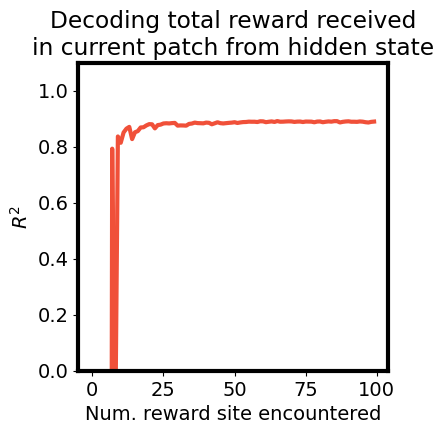

In [184]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

pred_accuracies = []
    
for i in range(0, 100):
    train_hidden = []
    test_hidden = []
    train_reward_params = []
    test_reward_params = []

    for env_idx in range(0, 160):
        session_data = all_session_data[env_idx]
        trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
        for k in range(3):
            for i_prime in range(i, i+1):
                if i_prime < len(trajs_by_patch_type[k]) - 20:
                    train_hidden.append(data[trajs_by_patch_type[k][i_prime], env_idx, :])
                    train_reward_params.append(session_data['rewards_seen_in_patch'][trajs_by_patch_type[k][i_prime]])

            for i_prime in range(1, 21):
                test_hidden.append(data[trajs_by_patch_type[k][-1-i_prime], env_idx, :])
                test_reward_params.append(session_data['rewards_seen_in_patch'][trajs_by_patch_type[k][-1-i_prime]]) 


    train_hidden = np.concatenate(train_hidden, axis=0)
    test_hidden = np.concatenate(test_hidden, axis=0)
    train_reward_params = np.concatenate(train_reward_params)
    test_reward_params = np.concatenate(test_reward_params)
    
    reg = LinearRegression().fit(train_hidden, train_reward_params)
    pred_accuracies.append(reg.score(test_hidden, test_reward_params))

axs.plot(np.arange(len(pred_accuracies)), pred_accuracies, c='#f05039', alpha=1, lw=3)
print(pred_accuracies)
axs.set_ylim(0, 1.1)
axs.set_ylabel(r'$R^2$')
axs.set_xlabel('Num. reward site encountered')
axs.set_title('Decoding total reward received\nin current patch from hidden state')

0.9115441134372794


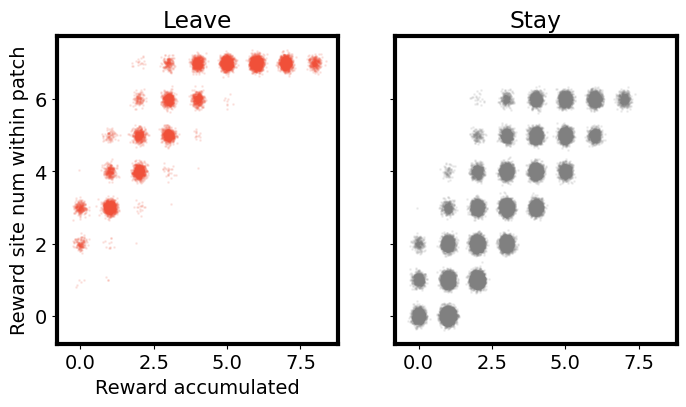

In [223]:
scale = 1
fig, axs = plt.subplots(1, 2, figsize=(8 * scale, 4 * scale), sharex=True, sharey=True)

pred_accuracies = []
    
leave = []
reward_accumulated = []
reward_site_indices = []

for env_idx in range(0, 160):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in range(3):
        last_reward_site_idx = None
        last_reward_accumulated_within_patch = None
        for i in range(len(trajs_by_patch_type[k])):
            reward_site_idx = session_data['reward_site_idx'][trajs_by_patch_type[k][i]][0]
            if last_reward_site_idx is not None:
                if last_reward_site_idx > reward_site_idx:
                    leave.append(True)
                else:
                    leave.append(False)
                reward_accumulated.append(last_reward_accumulated_within_patch)
                reward_site_indices.append(last_reward_site_idx)
            last_reward_site_idx = reward_site_idx
            last_reward_accumulated_within_patch = session_data['rewards_seen_in_patch'][trajs_by_patch_type[k][i]][-1]

leave = np.array(leave)
reward_site_indices = np.array(reward_site_indices)
reward_accumulated = np.array(reward_accumulated)

var = 0.1
noise_leave_x =  var * np.random.normal(size=np.count_nonzero(leave))
noise_leave_y =  var * np.random.normal(size=np.count_nonzero(leave))
noise_stay_x = var *  np.random.normal(size=np.count_nonzero(~leave))
noise_stay_y =  var * np.random.normal(size=np.count_nonzero(~leave))

axs[0].scatter(reward_accumulated[leave] + noise_leave_x, reward_site_indices[leave] + noise_leave_y, color='#f05039', s=1, alpha=0.1)
axs[1].scatter(reward_accumulated[~leave] + noise_stay_x, reward_site_indices[~leave] + noise_stay_y, color='grey', s=1, zorder=-1, alpha=0.1)

# print(pred_accuracies)
# axs.set_ylim(0, 1.1)
# axs.set_ylabel(r'$R^2$')
axs[0].set_xlabel('Reward accumulated')
axs[0].set_ylabel('Reward site num within patch')

axs[0].set_title('Leave')
axs[1].set_title('Stay')
# axs.set_title('Decoding total reward received\nin current patch from hidden state')

covariates = np.stack([reward_accumulated, reward_site_indices]).T

reg = LogisticRegression().fit(covariates[:40000], leave[:40000])
print(reg.score(covariates[40000:], leave[40000:]))